# KUBIG 24S NLP Basic Week 3

## Review 2

### 19기 정종락

$$
\\
$$

참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

# Import Libraries, Modules, and Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Othercomputers/My MacBook Pro/Colab/KUBIG/24S/NLP/Week 3/HW/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from datetime import datetime
import urllib.request
from collections import Counter

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 38.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 15.0 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=5f19ba86994e297f17b4556f3f27a6600a87cc72d4916fbec44a321e54aae379
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   353k      0  0:00:03  0:00:03 --:--:--  555k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/exampl

In [3]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [4]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


$$
\\
$$

# Preprocessing

In [5]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default = 0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data,
                                         test_size = 0.2,
                                         random_state = 42)

In [6]:
train_data['label'].value_counts()

label
1    80003
0    79923
Name: count, dtype: int64

### 데이터 정제 및 전처리

In [7]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

### 토큰화

In [8]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open(path + 'stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [9]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [10]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [11]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [12]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


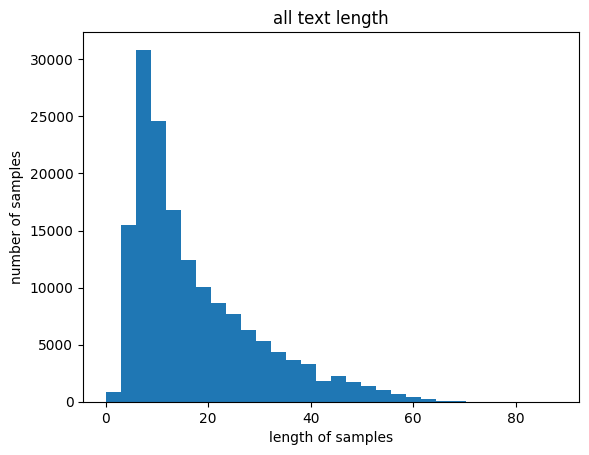

In [13]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [15]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [16]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [17]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [18]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [36]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [34]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [37]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.24521228671073914. Accuracy: 89.38772583007812
Iteration: 1000. Loss: 0.26035794615745544. Accuracy: 88.99504852294922
Iteration: 1500. Loss: 0.30283012986183167. Accuracy: 88.7874526977539
Iteration: 2000. Loss: 0.17537975311279297. Accuracy: 88.81246948242188
Iteration: 2500. Loss: 0.4364074170589447. Accuracy: 89.34020233154297
Iteration: 3000. Loss: 0.3088684678077698. Accuracy: 89.32269287109375
Iteration: 3500. Loss: 0.19218188524246216. Accuracy: 89.33769989013672
Iteration: 4000. Loss: 0.3114969730377197. Accuracy: 88.79496002197266
Iteration: 4500. Loss: 0.1332690268754959. Accuracy: 88.4397964477539
Iteration: 5000. Loss: 0.26987776160240173. Accuracy: 88.58736419677734
Iteration: 5500. Loss: 0.26030296087265015. Accuracy: 88.61988067626953
Iteration: 6000. Loss: 0.3763101398944855. Accuracy: 88.9050064086914
Iteration: 6500. Loss: 0.33698269724845886. Accuracy: 88.8199691772461
Iteration: 7000. Loss: 0.23953212797641754. Accuracy: 88.71742248535156
It

### 모델학습 (LSTM, Long short term memory)

In [38]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [39]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim,
                  hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [24]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.11289990693330765. Accuracy: 90.73332977294922
Iteration: 2000. Loss: 0.18900462985038757. Accuracy: 91.34610748291016
Iteration: 3000. Loss: 0.1967238187789917. Accuracy: 91.44364929199219
Iteration: 4000. Loss: 0.23138564825057983. Accuracy: 91.39612579345703
Iteration: 5000. Loss: 0.18985436856746674. Accuracy: 91.58621215820312
Iteration: 6000. Loss: 0.18581533432006836. Accuracy: 91.3661117553711
Iteration: 7000. Loss: 0.08365006744861603. Accuracy: 91.15852355957031
Iteration: 8000. Loss: 0.09290596097707748. Accuracy: 90.92591857910156
Iteration: 9000. Loss: 0.20487524569034576. Accuracy: 91.23855590820312
Iteration: 10000. Loss: 0.06086471304297447. Accuracy: 91.2260513305664
Iteration: 11000. Loss: 0.12064112722873688. Accuracy: 90.53324127197266
Iteration: 12000. Loss: 0.24038070440292358. Accuracy: 90.80085754394531
Iteration: 13000. Loss: 0.10597983747720718. Accuracy: 90.70331573486328
Iteration: 14000. Loss: 0.10652622580528259. Accuracy: 90.70832

### 모델 학습 (Gated Recurrent Unit (GRU))

In [25]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [26]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

criterion = nn.CrossEntropyLoss()

In [27]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.30606934428215027. Accuracy: 90.725830078125
Iteration: 2000. Loss: 0.22462911903858185. Accuracy: 90.87089538574219
Iteration: 3000. Loss: 0.20429442822933197. Accuracy: 91.68376159667969
Iteration: 4000. Loss: 0.3168197572231293. Accuracy: 91.55370330810547
Iteration: 5000. Loss: 0.2093840092420578. Accuracy: 91.63874053955078
Iteration: 6000. Loss: 0.17042694985866547. Accuracy: 91.6512451171875
Iteration: 7000. Loss: 0.18429313600063324. Accuracy: 91.67875671386719
Iteration: 8000. Loss: 0.12261102348566055. Accuracy: 91.44615173339844
Iteration: 9000. Loss: 0.3247942626476288. Accuracy: 91.24356079101562
Iteration: 10000. Loss: 0.1393461674451828. Accuracy: 91.50617980957031
Iteration: 11000. Loss: 0.10523122549057007. Accuracy: 91.11600494384766
Iteration: 12000. Loss: 0.14493940770626068. Accuracy: 91.07848358154297
Iteration: 13000. Loss: 0.0669708251953125. Accuracy: 91.12350463867188
Iteration: 14000. Loss: 0.1098174974322319. Accuracy: 91.22605133056

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

In [29]:
import time
import matplotlib.pyplot as plt

### RNN
### adjust `num_epoch`, `batch_size`, ...
### `AdamW`, `lr = 0.001`, `weight_decay = 0.01`

In [46]:
num_epoch = 20
batch_size = 32
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)

# New optimizer with learing rate 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.01)

criterion = nn.CrossEntropyLoss()

In [47]:
rnn_losses = []
rnn_start_time = time.time()

In [48]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        rnn_losses.append(loss.item())

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

rnn_end_time = time.time()
rnn_training_time = rnn_end_time - rnn_start_time

Iteration: 500. Loss: 0.4111568331718445. Accuracy: 79.19564056396484
Iteration: 1000. Loss: 0.23084577918052673. Accuracy: 85.42093658447266
Iteration: 1500. Loss: 0.36966416239738464. Accuracy: 87.72197723388672
Iteration: 2000. Loss: 0.33518531918525696. Accuracy: 87.0491714477539
Iteration: 2500. Loss: 0.32143497467041016. Accuracy: 89.28768157958984
Iteration: 3000. Loss: 0.35399919748306274. Accuracy: 89.30268859863281
Iteration: 3500. Loss: 0.3908807635307312. Accuracy: 89.73788452148438
Iteration: 4000. Loss: 0.16543172299861908. Accuracy: 89.92296600341797
Iteration: 4500. Loss: 0.15920911729335785. Accuracy: 90.09053802490234
Iteration: 5000. Loss: 0.19520419836044312. Accuracy: 90.34815979003906
Iteration: 5500. Loss: 0.29020893573760986. Accuracy: 90.35565948486328
Iteration: 6000. Loss: 0.2182856947183609. Accuracy: 90.59076690673828
Iteration: 6500. Loss: 0.368813157081604. Accuracy: 90.40818786621094
Iteration: 7000. Loss: 0.2943764626979828. Accuracy: 90.62078094482422


$$
\\
$$

### LSTM
### adjust `num_epoch`, `batch_size`, ...
### `AdamW`, `lr = 0.001`, `weight_decay = 0.01`

In [49]:
num_epoch = 20
batch_size = 32
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4


model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.3, device)
model = model.to(device)

# AdamW optimizer with different learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.01)

criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [50]:
lstm_losses = []
lstm_start_time = time.time()

In [51]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        lstm_losses.append(loss.item())

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

lstm_end_time = time.time()
lstm_training_time = lstm_end_time - lstm_start_time

Iteration: 1000. Loss: 0.2853524684906006. Accuracy: 86.07123565673828
Iteration: 2000. Loss: 0.24479593336582184. Accuracy: 89.13261413574219
Iteration: 3000. Loss: 0.2855670154094696. Accuracy: 89.92296600341797
Iteration: 4000. Loss: 0.19563867151737213. Accuracy: 90.43069458007812
Iteration: 5000. Loss: 0.2061203569173813. Accuracy: 90.74333190917969
Iteration: 6000. Loss: 0.1638527363538742. Accuracy: 91.08599090576172
Iteration: 7000. Loss: 0.15367384254932404. Accuracy: 91.02596282958984
Iteration: 8000. Loss: 0.19542893767356873. Accuracy: 91.30609130859375
Iteration: 9000. Loss: 0.2401965707540512. Accuracy: 91.39363098144531
Iteration: 10000. Loss: 0.0871826782822609. Accuracy: 91.40613555908203
Iteration: 11000. Loss: 0.11290227621793747. Accuracy: 91.4836654663086
Iteration: 12000. Loss: 0.13291996717453003. Accuracy: 91.59121704101562
Iteration: 13000. Loss: 0.06630319356918335. Accuracy: 91.45115661621094
Iteration: 14000. Loss: 0.2385513037443161. Accuracy: 91.3836212158

$$
\\
$$

### GRU

### adjust `num_epoch`, `batch_size`, ...
### `AdamW`, `lr = 0.001`, `weight_decay = 0.01`

In [52]:
num_epoch = 20
batch_size = 32
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.3, device)
model = model.to(device)

# Define optimizer with different learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.01)

criterion = nn.CrossEntropyLoss()

In [53]:
gru_losses = []
gru_start_time = time.time()

In [54]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        gru_losses.append(loss.item())

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

gru_end_time = time.time()
gru_training_time = gru_end_time - gru_start_time

Iteration: 1000. Loss: 0.36360248923301697. Accuracy: 87.63443756103516
Iteration: 2000. Loss: 0.17469213902950287. Accuracy: 89.54779815673828
Iteration: 3000. Loss: 0.2248995304107666. Accuracy: 90.04302215576172
Iteration: 4000. Loss: 0.25076842308044434. Accuracy: 90.73833465576172
Iteration: 5000. Loss: 0.1349717527627945. Accuracy: 91.09349060058594
Iteration: 6000. Loss: 0.1660601943731308. Accuracy: 90.89089965820312
Iteration: 7000. Loss: 0.21464960277080536. Accuracy: 91.08849334716797
Iteration: 8000. Loss: 0.19835637509822845. Accuracy: 91.37361907958984
Iteration: 9000. Loss: 0.25312840938568115. Accuracy: 91.45865631103516
Iteration: 10000. Loss: 0.24762758612632751. Accuracy: 91.52118682861328
Iteration: 11000. Loss: 0.2132931500673294. Accuracy: 91.50367736816406
Iteration: 12000. Loss: 0.2879643142223358. Accuracy: 91.59622192382812
Iteration: 13000. Loss: 0.3159451484680176. Accuracy: 91.66374969482422
Iteration: 14000. Loss: 0.06773725152015686. Accuracy: 91.56871032

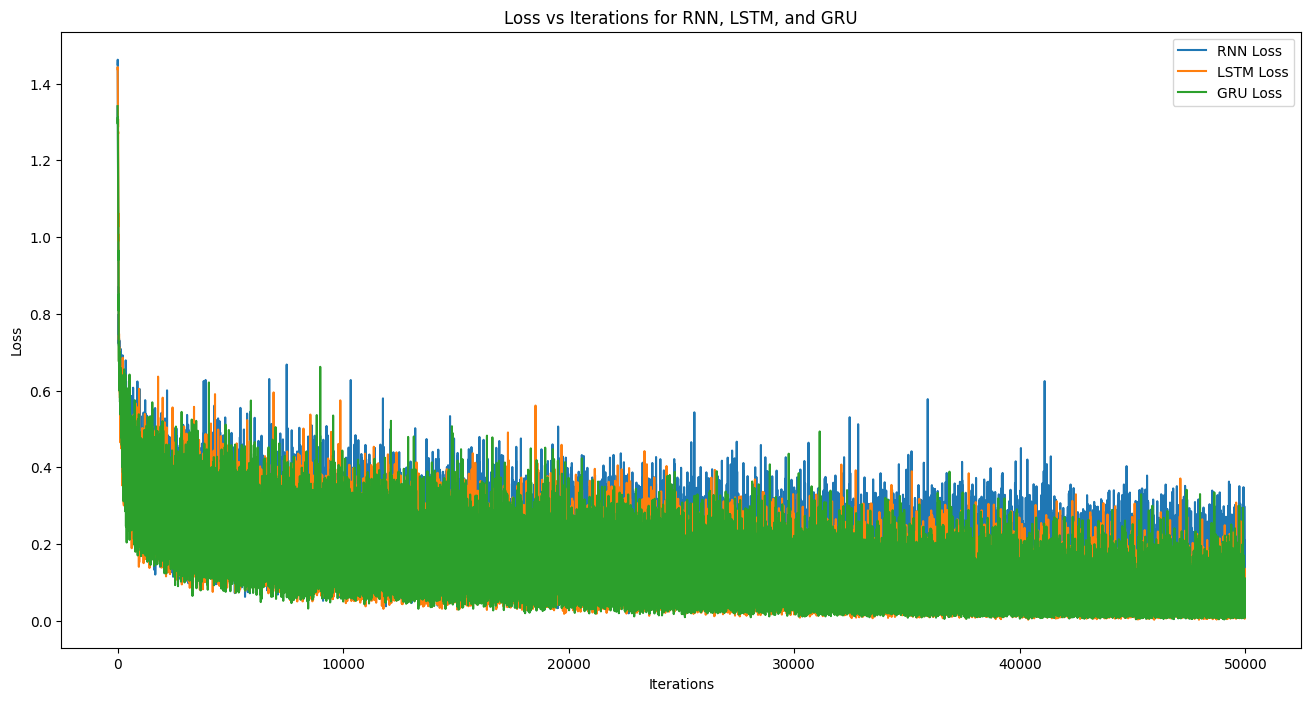

In [57]:
plt.figure(figsize = (16, 8))

# Plot loss for RNN
plt.plot(rnn_losses, label = 'RNN Loss')

# Plot loss for LSTM
plt.plot(lstm_losses, label = 'LSTM Loss')

# Plot loss for GRU
plt.plot(gru_losses, label = 'GRU Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations for RNN, LSTM, and GRU')
plt.legend()
plt.show()

In [58]:
print(f'RNN Training Time: {rnn_training_time:.2f} seconds')
print(f'LSTM Training Time: {lstm_training_time:.2f} seconds')
print(f'GRU Training Time: {gru_training_time:.2f} seconds')

RNN Training Time: 246.90 seconds
LSTM Training Time: 199.35 seconds
GRU Training Time: 202.56 seconds


이전에 비해 RNN의 성능이 조금 나아지긴 했으나

여전히 LSTM, GRU보다는 좋지는 않은 것 같다.

공통적으로 세 모델 모두 그다지 수렴하지 않는 것 같은..?

학습에 걸리는 시간을 보면 RNN이 LSTM, GRU에 비해 더 오래 걸리는 것도 확인 가능